
**MOVIE RECOMMENDATION SYSTEM**



In [1]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("reshape2")
install.packages("recommenderlab")


In [ ]:
%%R
install.packages("data.table")
install.packages("ggplot2")

In [ ]:
%%R
#importing the necessary libraries
library(recommenderlab)
library(ggplot2)
library(data.table)
library(reshape2)

In [ ]:
from google.colab import files


uploaded = files.upload()


In [ ]:
from google.colab import files


uploaded = files.upload()

In [7]:
%%R
#reading the data 
movies <- read.csv("movies.csv",stringsAsFactors=FALSE)


In [8]:
%%R
ratings <- read.csv("ratings.csv")


In [9]:
%%R
summary(movies)

    movieId          title              genres         
 Min.   :     1   Length:10329       Length:10329      
 1st Qu.:  3240   Class :character   Class :character  
 Median :  7088   Mode  :character   Mode  :character  
 Mean   : 31924                                        
 3rd Qu.: 59900                                        
 Max.   :149532                                        


In [10]:
%%R

head(movies)

  movieId                              title
1       1                   Toy Story (1995)
2       2                     Jumanji (1995)
3       3            Grumpier Old Men (1995)
4       4           Waiting to Exhale (1995)
5       5 Father of the Bride Part II (1995)
6       6                        Heat (1995)
                                       genres
1 Adventure|Animation|Children|Comedy|Fantasy
2                  Adventure|Children|Fantasy
3                              Comedy|Romance
4                        Comedy|Drama|Romance
5                                      Comedy
6                       Action|Crime|Thriller


In [11]:
%%R
summary(ratings)

     userId         movieId           rating        timestamp        
 Min.   :  1.0   Min.   :     1   Min.   :0.500   Min.   :8.286e+08  
 1st Qu.:192.0   1st Qu.:  1073   1st Qu.:3.000   1st Qu.:9.711e+08  
 Median :383.0   Median :  2497   Median :3.500   Median :1.115e+09  
 Mean   :364.9   Mean   : 13381   Mean   :3.517   Mean   :1.130e+09  
 3rd Qu.:557.0   3rd Qu.:  5991   3rd Qu.:4.000   3rd Qu.:1.275e+09  
 Max.   :668.0   Max.   :149532   Max.   :5.000   Max.   :1.452e+09  


In [12]:
%%R
head(ratings)

  userId movieId rating  timestamp
1      1      16    4.0 1217897793
2      1      24    1.5 1217895807
3      1      32    4.0 1217896246
4      1      47    4.0 1217896556
5      1      50    4.0 1217896523
6      1     110    4.0 1217896150


##Data pre-processing

re-organize the information of movie genres in such a way that allows future users to search for the movies they like within specific genres

In [13]:
%%R
#Extract a list of genres
#encoding to create a matrix of corresponding genres for each movie.

genres <- as.data.frame(movies$genres, stringsAsFactors=FALSE)
genres2 <- as.data.frame(tstrsplit(genres[,1], '[|]', type.convert=TRUE), stringsAsFactors=FALSE)
colnames(genres2) <- c(1:10)
# we have 18 genres in total
genre_list <- c("Action", "Adventure", "Animation", "Children", 
                "Comedy", "Crime","Documentary", "Drama", "Fantasy",
                "Film-Noir", "Horror", "Musical", "Mystery","Romance",
                "Sci-Fi", "Thriller", "War", "Western")
genre_matrix <- matrix(0,10330,18)
genre_matrix[1,] <- genre_list

In [14]:
%%R
colnames(genre_matrix) <- genre_list
#iterate through matrix
for (i in 1:nrow(genres2)) {
  for (c in 1:ncol(genres2)) {
    genmat_col = which(genre_matrix[1,] == genres2[i,c])
    genre_matrix[i+1,genmat_col] <- 1
  }
}
genre_matrix2 <- as.data.frame(genre_matrix[-1,], stringsAsFactors=FALSE)
for (c in 1:ncol(genre_matrix2)) {
  genre_matrix2[,c] <- as.integer(genre_matrix2[,c])
}


In [15]:
%%R
head(genre_matrix2)

  Action Adventure Animation Children Comedy Crime Documentary Drama Fantasy
1      0         1         1        1      1     0           0     0       1
2      0         1         0        1      0     0           0     0       1
3      0         0         0        0      1     0           0     0       0
4      0         0         0        0      1     0           0     1       0
5      0         0         0        0      1     0           0     0       0
6      1         0         0        0      0     1           0     0       0
  Film-Noir Horror Musical Mystery Romance Sci-Fi Thriller War Western
1         0      0       0       0       0      0        0   0       0
2         0      0       0       0       0      0        0   0       0
3         0      0       0       0       1      0        0   0       0
4         0      0       0       0       1      0        0   0       0
5         0      0       0       0       0      0        0   0       0
6         0      0       0       0 

In [16]:
%%R
# Create a matrix to search for a movie by genre
search_matrix <- cbind(movies[,1:2], genre_matrix2)
head(search_matrix)

  movieId                              title Action Adventure Animation
1       1                   Toy Story (1995)      0         1         1
2       2                     Jumanji (1995)      0         1         0
3       3            Grumpier Old Men (1995)      0         0         0
4       4           Waiting to Exhale (1995)      0         0         0
5       5 Father of the Bride Part II (1995)      0         0         0
6       6                        Heat (1995)      1         0         0
  Children Comedy Crime Documentary Drama Fantasy Film-Noir Horror Musical
1        1      1     0           0     0       1         0      0       0
2        1      0     0           0     0       1         0      0       0
3        0      1     0           0     0       0         0      0       0
4        0      1     0           0     1       0         0      0       0
5        0      1     0           0     0       0         0      0       0
6        0      0     1           0     0     

In [17]:
%%R
#Converting ratings matrix in a proper format
ratingmat <- dcast(ratings, userId~movieId, value.var = "rating", na.rm=FALSE)
ratingmat <- as.matrix(ratingmat[,-1])
ratingmat <- as(ratingmat, "realRatingMatrix")
ratingmat

668 x 10325 rating matrix of class ‘realRatingMatrix’ with 105339 ratings.


In [18]:
%%R
#Exploring Parameters of Recommendation Models
recommender_models <- recommenderRegistry$get_entries(dataType = "realRatingMatrix")
names(recommender_models)

 [1] "HYBRID_realRatingMatrix"       "ALS_realRatingMatrix"         
 [3] "ALS_implicit_realRatingMatrix" "IBCF_realRatingMatrix"        
 [5] "LIBMF_realRatingMatrix"        "POPULAR_realRatingMatrix"     
 [7] "RANDOM_realRatingMatrix"       "RERECOMMEND_realRatingMatrix" 
 [9] "SVD_realRatingMatrix"          "SVDF_realRatingMatrix"        
[11] "UBCF_realRatingMatrix"        


In [26]:
%%R

lapply(recommender_models, "[[", "description")


$HYBRID_realRatingMatrix
[1] "Hybrid recommender that aggegates several recommendation strategies using weighted averages."

$ALS_realRatingMatrix
[1] "Recommender for explicit ratings based on latent factors, calculated by alternating least squares algorithm."

$ALS_implicit_realRatingMatrix
[1] "Recommender for implicit data based on latent factors, calculated by alternating least squares algorithm."

$IBCF_realRatingMatrix
[1] "Recommender based on item-based collaborative filtering."

$LIBMF_realRatingMatrix
[1] "Matrix factorization with LIBMF via package recosystem (https://cran.r-project.org/web/packages/recosystem/vignettes/introduction.html)."

$POPULAR_realRatingMatrix
[1] "Recommender based on item popularity."

$RANDOM_realRatingMatrix
[1] "Produce random recommendations (real ratings)."

$RERECOMMEND_realRatingMatrix
[1] "Re-recommends highly rated items (real ratings)."

$SVD_realRatingMatrix
[1] "Recommender based on SVD approximation with column-mean imputation."

$SVDF

In [27]:
%%R
recommender_models$IBCF_realRatingMatrix$parameters

$k
[1] 30

$method
[1] "Cosine"

$normalize
[1] "center"

$normalize_sim_matrix
[1] FALSE

$alpha
[1] 0.5

$na_as_zero
[1] FALSE



In [28]:
%%R
recommender_models$UBCF_realRatingMatrix$parameters

$method
[1] "cosine"

$nn
[1] 25

$sample
[1] FALSE

$weighted
[1] TRUE

$normalize
[1] "center"

$min_matching_items
[1] 0

$min_predictive_items
[1] 0



Exploring Similarity Data

In [29]:
%%R
#Collaborative filtering algorithms are based on measuring the similarity between users or between items. 
similarity_users <- similarity(ratingmat[1:12, ], 
                               method = "cosine", 
                               which = "users")
as.matrix(similarity_users)

           1         2         3         4         5         6         7
1  0.0000000 0.9760860 0.9641723 0.9914398 0.8359111 0.9918166 0.9677533
2  0.9760860 0.0000000 0.9925732 0.9374253 1.0000000 1.0000000 0.9732709
3  0.9641723 0.9925732 0.0000000 0.9888968 0.8414317 1.0000000 0.9171903
4  0.9914398 0.9374253 0.9888968 0.0000000 0.7957734 1.0000000 0.9180299
5  0.8359111 1.0000000 0.8414317 0.7957734 0.0000000 0.8915476 0.8687099
6  0.9918166 1.0000000 1.0000000 1.0000000 0.8915476 0.0000000 0.9606265
7  0.9677533 0.9732709 0.9171903 0.9180299 0.8687099 0.9606265 0.0000000
8  0.9829068 0.9719133 0.9940390 0.9374253 0.9938837 1.0000000 0.9687383
9  0.9637003 0.9610288 0.9544297 0.9493423 0.7340177 1.0000000 0.9564847
10 0.9216354        NA 0.9312404        NA 1.0000000 0.9736163 1.0000000
11 0.9804446 0.9517898 0.9647574 0.9659715 0.8865295 0.9712516 0.9675114
12 0.9474403 1.0000000 1.0000000 1.0000000        NA        NA 0.8660565
           8         9        10        11        1

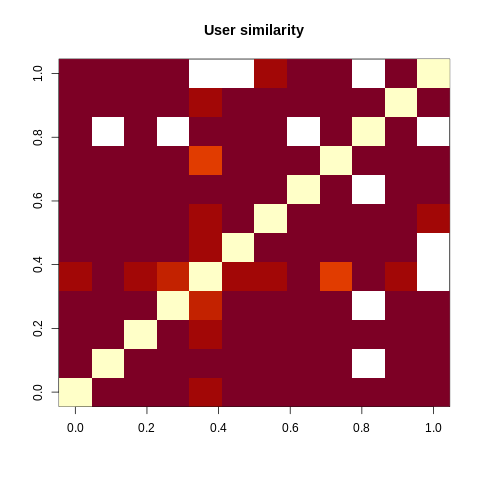

In [30]:
%%R
#each row and each column corresponds to a user, and each cell corresponds to the similarity between two users.
image(as.matrix(similarity_users), main = "User similarity")

In [31]:
%%R
similarity_items <- similarity(ratingmat[, 1:12], method =
                                 "cosine", which = "items")
as.matrix(similarity_items)

           1         2         3         4         5         6         7
1  0.0000000 0.9669732 0.9559341 0.9101276 0.9531838 0.9611291 0.9609033
2  0.9669732 0.0000000 0.9658757 0.9412416 0.9603386 0.9531442 0.9456375
3  0.9559341 0.9658757 0.0000000 0.9864877 0.9658946 0.9502471 0.9614828
4  0.9101276 0.9412416 0.9864877 0.0000000 0.9345030 0.9772545 0.9897595
5  0.9531838 0.9603386 0.9658946 0.9345030 0.0000000 0.9491592 0.9743898
6  0.9611291 0.9531442 0.9502471 0.9772545 0.9491592 0.0000000 0.9697378
7  0.9609033 0.9456375 0.9614828 0.9897595 0.9743898 0.9697378 0.0000000
8  0.9938837 1.0000000 0.9899495 1.0000000 0.9995121 1.0000000        NA
9  0.8427010 0.9781386 0.8827704 1.0000000 0.9658814 0.9279429 0.8957936
10 0.9786042 0.9675372 0.9726710 0.9365858 0.9649127 0.9799504 0.9713049
11 0.9592915 0.9722052 0.9721035 0.9627784 0.9657816 0.9636291 0.9761076
12 0.8996062 0.9526429 0.9257562 1.0000000 0.9684156 0.9295455 0.9402524
           8         9        10        11        1

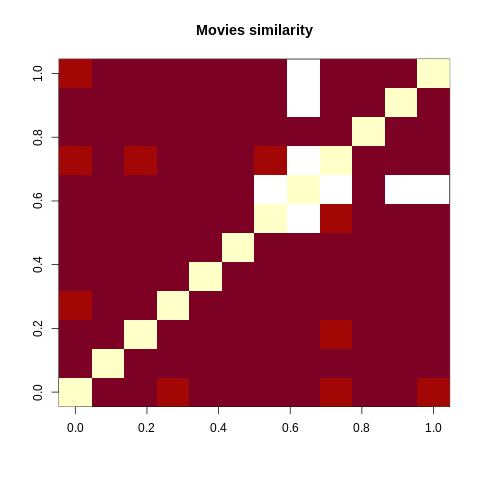

In [32]:
%%R
#similarity between the first four movies
image(as.matrix(similarity_items), main = "Movies similarity")

In [33]:
%%R
vector_ratings <- as.vector(ratingmat@data)
unique(vector_ratings)

 [1] 0.0 5.0 4.0 3.0 4.5 1.5 2.0 3.5 1.0 2.5 0.5


In [34]:
%%R
table_ratings <- table(vector_ratings) # what is the count of each rating value
table_ratings

vector_ratings
      0     0.5       1     1.5       2     2.5       3     3.5       4     4.5 
6791761    1198    3258    1567    7943    5484   21729   12237   28880    8187 
      5 
  14856 


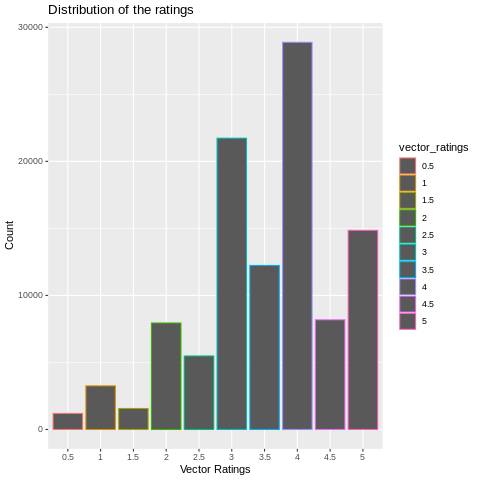

In [35]:
%%R 
#Distribution of the ratings and removing null values
vector_ratings <- vector_ratings[vector_ratings != 0] # rating == 0 are NA values
vector_ratings <- factor(vector_ratings)
qplot(vector_ratings,xlab="Vector Ratings",ylab="Count",color=vector_ratings) + 
  ggtitle("Distribution of the ratings")

In [37]:
%%R
#Number of views of the top movies
views_per_movie <- colCounts(ratingmat)
table_views <- data.frame(movie = names(views_per_movie),
                          views = views_per_movie)
table_views <- table_views[order(table_views$views, 
                                 decreasing = TRUE), ]
table_views$title <- NA
for (i in 1:10325){
  table_views[i,3] <- as.character(subset(movies, 
                                          movies$movieId == table_views[i,1])$title)
}
table_views[1:6,]

    movie views                                     title
296   296   325                       Pulp Fiction (1994)
356   356   311                       Forrest Gump (1994)
318   318   308          Shawshank Redemption, The (1994)
480   480   294                      Jurassic Park (1993)
593   593   290          Silence of the Lambs, The (1991)
260   260   273 Star Wars: Episode IV - A New Hope (1977)


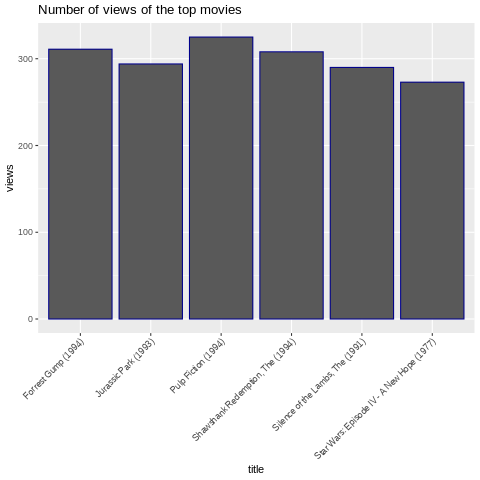

In [38]:
%%R
ggplot(table_views[1:6, ], aes(x = title, y = views)) +
  geom_bar(stat="identity",color="darkblue") + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
  ggtitle("Number of views of the top movies")

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



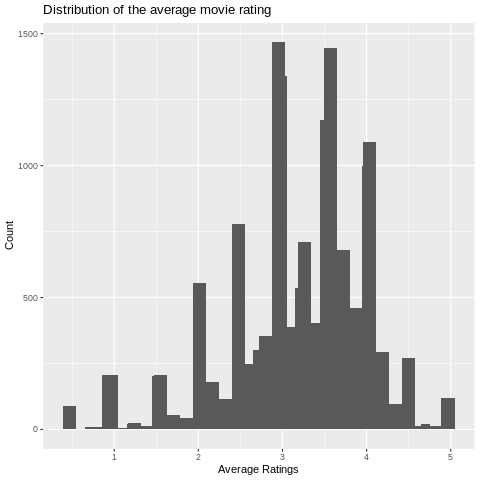

In [39]:
%%R
#identifying the top-rated movies by computing the average rating of each of them
average_ratings <- colMeans(ratingmat)
qplot(average_ratings,xlab="Average Ratings",ylab="Count",color=average_ratings) + 
  stat_bin(binwidth = 0.1) +
  ggtitle("Distribution of the average movie rating")

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



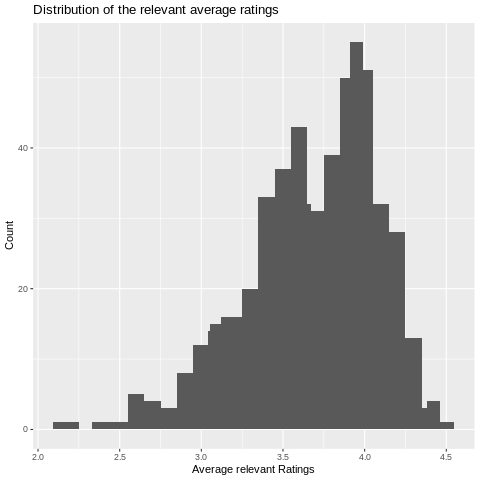

In [40]:
%%R
#subset of only relevant movies ie movies with view higher than 50
average_ratings_relevant <- average_ratings[views_per_movie > 50] 
qplot(average_ratings_relevant,xlab="Average relevant Ratings",ylab="Count",color=average_ratings_relevant) + 
  stat_bin(binwidth = 0.1) +
  ggtitle(paste("Distribution of the relevant average ratings"))

Heatmaps


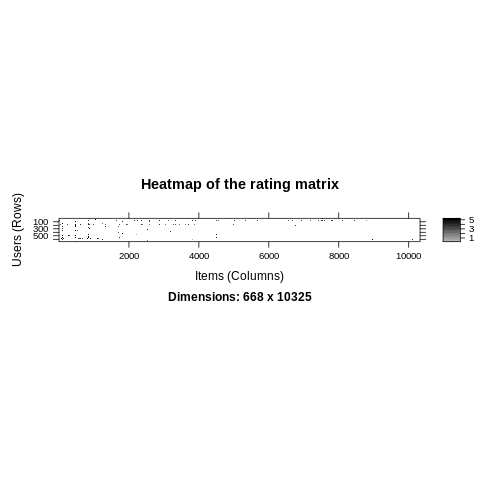

In [41]:
%%R
image(ratingmat, main = "Heatmap of the rating matrix")

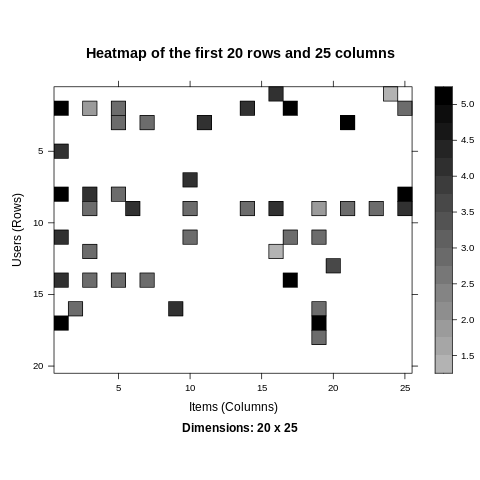

In [42]:
%%R
image(ratingmat[1:20, 1:25], main = "Heatmap of the first 20 rows and 25 columns")


In [43]:
%%R
min_n_movies <- quantile(rowCounts(ratingmat), 0.99)
min_n_users <- quantile(colCounts(ratingmat), 0.99)
print("Minimum number of movies per user:")
min_n_movies
print("Minimum number of users per movie:")
min_n_users


[1] "Minimum number of movies per user:"
[1] "Minimum number of users per movie:"
99% 
115 


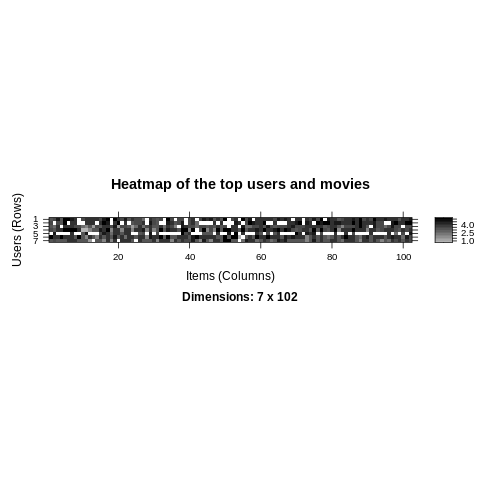

In [44]:
%%R
image(ratingmat[rowCounts(ratingmat) > min_n_movies,
                colCounts(ratingmat) > min_n_users], 
      main = "Heatmap of the top users and movies")

##Data preparation 

In [45]:
%%R
ratings_movies <- ratingmat[rowCounts(ratingmat) > 50,
                            colCounts(ratingmat) > 50]
ratings_movies

420 x 447 rating matrix of class ‘realRatingMatrix’ with 38341 ratings.


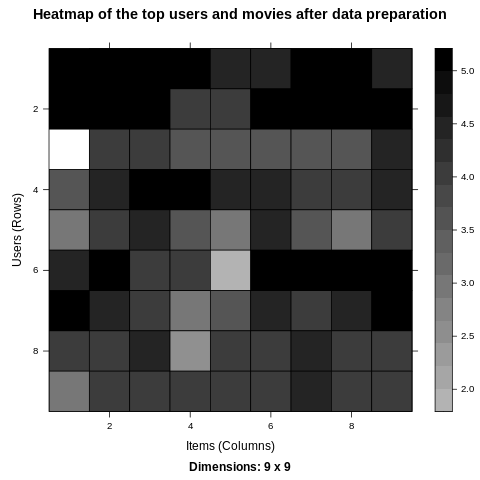

In [46]:
%%R
min_movies <- quantile(rowCounts(ratings_movies), 0.98)
min_users <- quantile(colCounts(ratings_movies), 0.98)

image(ratings_movies[rowCounts(ratings_movies) > min_movies,
                     colCounts(ratings_movies) > min_users], 
      main = "Heatmap of the top users and movies after data preparation")

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



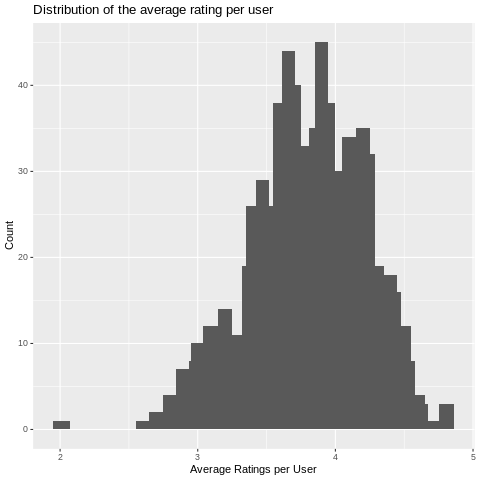

In [47]:
%%R
average_ratings_per_user <- rowMeans(ratings_movies)

qplot(average_ratings_per_user,xlab="Average Ratings per User",ylab="Count",color=average_ratings_per_user) + stat_bin(binwidth = 0.1) +
  ggtitle("Distribution of the average rating per user")

In [48]:
%%R
#Normalizing data(the average rating of each user is 0)
ratings_movies_norm <- normalize(ratings_movies)
sum(rowMeans(ratings_movies_norm) > 0.00001)


[1] 0


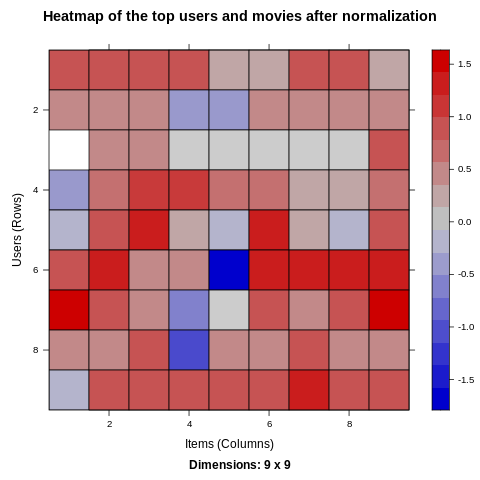

In [49]:
%%R
image(ratings_movies_norm[rowCounts(ratings_movies_norm) > min_movies,
                          colCounts(ratings_movies_norm) > min_users], 
      main = "Heatmap of the top users and movies after normalization")

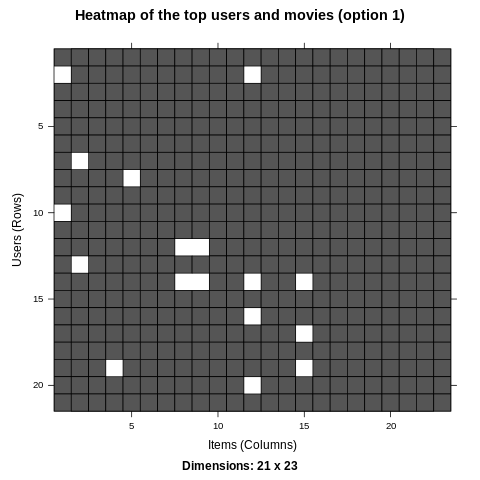

In [50]:
%%R
#Binarizing data(define a table containing only 0s and 1s)
#1st option: define a matrix equal to 1 if the movie has been watched
ratings_movies_watched <- binarize(ratings_movies, minRating = 1)
min_movies_binary <- quantile(rowCounts(ratings_movies), 0.95)
min_users_binary <- quantile(colCounts(ratings_movies), 0.95)
image(ratings_movies_watched[rowCounts(ratings_movies) > min_movies_binary,
                             colCounts(ratings_movies) > min_users_binary], 
      main = "Heatmap of the top users and movies (option 1)")

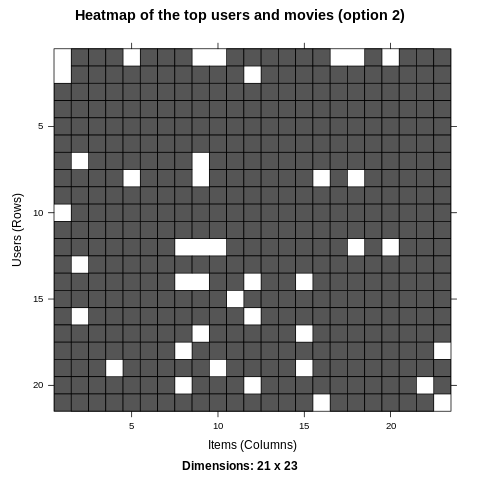

In [51]:
%%R
#2nd option: define a matrix equal to 1 if the cell has a rating above the threshold
ratings_movies_good <- binarize(ratings_movies, minRating = 3)
image(ratings_movies_good[rowCounts(ratings_movies) > min_movies_binary, 
                          colCounts(ratings_movies) > min_users_binary], 
      main = "Heatmap of the top users and movies (option 2)")


##ITEM-based Collaborative Filtering Model

In [52]:
%%R
#training the data set for IBCF 80% as a training set and 20% as a test set
which_train <- sample(x = c(TRUE, FALSE), 
                      size = nrow(ratings_movies),
                      replace = TRUE, 
                      prob = c(0.8, 0.2))
recc_data_train <- ratings_movies[which_train, ]
recc_data_test <- ratings_movies[!which_train, ]

#BUILDING THE RECOMMENDER MODEL using the default parameters of method = Cosine and k=30
recommender_models <- recommenderRegistry$get_entries(dataType ="realRatingMatrix")
recommender_models$IBCF_realRatingMatrix$parameters
recc_model <- Recommender(data = recc_data_train, 
                          method = "IBCF",
                          parameter = list(k = 30))
recc_model
class(recc_model)



[1] "Recommender"
attr(,"package")
[1] "recommenderlab"


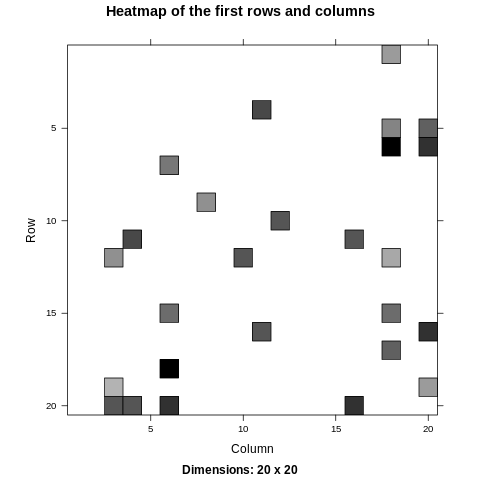

In [53]:
%%R

model_details <- getModel(recc_model)
class(model_details$sim) # this contains a similarity matrix
dim(model_details$sim)
n_items_top <- 20
#generating a heatmap of the first 20 rows and columns:
image(model_details$sim[1:n_items_top, 1:n_items_top],
      main = "Heatmap of the first rows and columns")

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



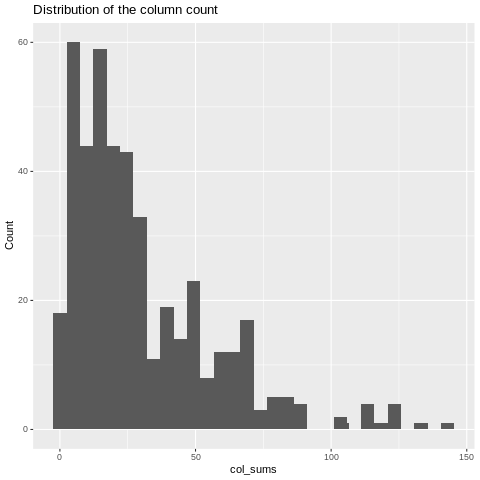

In [54]:
%%R
#generating a bar plot of the distribution count 
row_sums <- rowSums(model_details$sim > 0)
table(row_sums)
col_sums <- colSums(model_details$sim > 0)
qplot(col_sums, ylab="Count") + stat_bin(binwidth = 1) + ggtitle("Distribution of the column count")


In [55]:
%%R
#applying the recommender system to the dataset 
n_recommended <- 10  #the number of items to recommend to each user
recc_predicted <- predict(object = recc_model, 
                          newdata = recc_data_test, 
                          n = n_recommended)
recc_predicted


Recommendations as ‘topNList’ with n = 10 for 88 users. 


In [56]:
%%R
#results of recommendation of the first user
recc_user_1 <- recc_predicted@items[[1]] #recommendation for the first user
movies_user_1 <- recc_predicted@itemLabels[recc_user_1]
movies_user_2 <- movies_user_1
for (i in 1:10){
  movies_user_2[i] <- as.character(subset(movies, 
                                         movies$movieId == movies_user_1[i])$title)
}
movies_user_2

 [1] "Dead Man Walking (1995)"                   
 [2] "Seven (a.k.a. Se7en) (1995)"               
 [3] "Rumble in the Bronx (Hont faan kui) (1995)"
 [4] "Congo (1995)"                              
 [5] "French Kiss (1995)"                        
 [6] "Legends of the Fall (1994)"                
 [7] "Santa Clause, The (1994)"                  
 [8] "Flintstones, The (1994)"                   
 [9] "Four Weddings and a Funeral (1994)"        
[10] "Much Ado About Nothing (1993)"             


In [57]:
%%R
#recommendation of each user can be shown as a matrix
recc_matrix <- sapply(recc_predicted@items, 
                      function(x){ as.integer(colnames(ratings_movies)[x]) }) # matrix with the recommendations for each user
#dim(recc_matrix)
recc_matrix[,1:4] #reccomendations for first 4 users (columns) and movieId values of recommended 10 movies (rows)

      [,1] [,2] [,3]  [,4]
 [1,]   36    7    1   648
 [2,]   47   44    2  1088
 [3,]  112   50    3 68358
 [4,]  160  161    5   539
 [5,]  236  266    6  5418
 [6,]  266  527    7   509
 [7,]  317  597   10  3753
 [8,]  355 1094   11   168
 [9,]  357 1097   17  1573
[10,]  497 1199   21    16


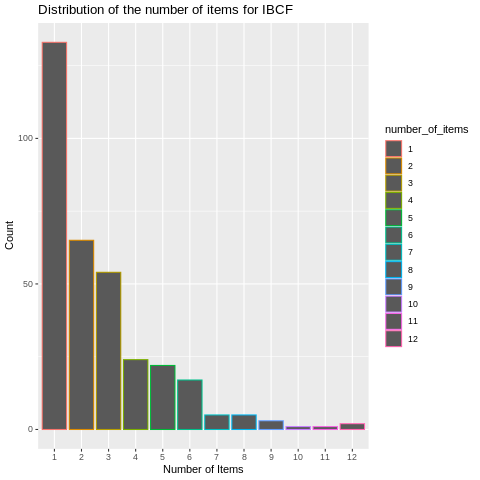

In [58]:
%%R
#plot of the most recommended movies using IBCF
number_of_items <- factor(table(recc_matrix))
chart_title <- "Distribution of the number of items for IBCF"
qplot(number_of_items,xlab="Number of Items",ylab="Count",color=number_of_items) + ggtitle(chart_title)


In [59]:
%%R
#Number of recommended how many number of times (top 4)
number_of_items_sorted <- sort(number_of_items, decreasing = TRUE)
number_of_items_top <- head(number_of_items_sorted, n = 4)
table_top <- data.frame(as.integer(names(number_of_items_top)),
                       number_of_items_top)
for (i in 1:4){
  table_top[i,1] <- as.character(subset(movies, 
                                         movies$movieId == table_top[i,1])$title)
}
colnames(table_top) <- c("Movie title", "No of items")
head(table_top)

                     Movie title No of items
3        Grumpier Old Men (1995)          12
17  Sense and Sensibility (1995)          12
7                 Sabrina (1995)          11
151               Rob Roy (1995)          10


##USER BASED COLLABORATIVE FILTERING MODEL 

In [60]:
%%R
#USER BASED COLLABORATIVE FILTERING MODEL 
recommender_models <- recommenderRegistry$get_entries(dataType ="realRatingMatrix")
recommender_models$UBCF_realRatingMatrix$parameters
recc_model <- Recommender(data = recc_data_train, method = "UBCF")
recc_model
model_details <- getModel(recc_model)
#names(model_details)
model_details$data


332 x 447 rating matrix of class ‘realRatingMatrix’ with 29528 ratings.
Normalized using center on rows.


In [61]:
%%R 
n_recommended <- 10
recc_predicted <- predict(object = recc_model,
                          newdata = recc_data_test, 
                          n = n_recommended) 
recc_predicted


Recommendations as ‘topNList’ with n = 10 for 88 users. 


In [62]:
%%R
#exploring results of the first four results 
recc_matrix <- sapply(recc_predicted@items, 
                      function(x){ as.integer(colnames(ratings_movies)[x]) })
#dim(recc_matrix)
recc_matrix[, 1:4]

      [,1] [,2]  [,3] [,4]
 [1,] 1784 1276  5010 1213
 [2,]  805  339  2916 2997
 [3,] 2167  357 33493 1396
 [4,] 2396 1247 51662 1673
 [5,]  778 2078  1201   39
 [6,] 1136  587  3996 1252
 [7,]   50  953   260 4720
 [8,] 1479 1396   163 2268
 [9,] 2278 1673  2617 1250
[10,] 5010 2406  1275 4027


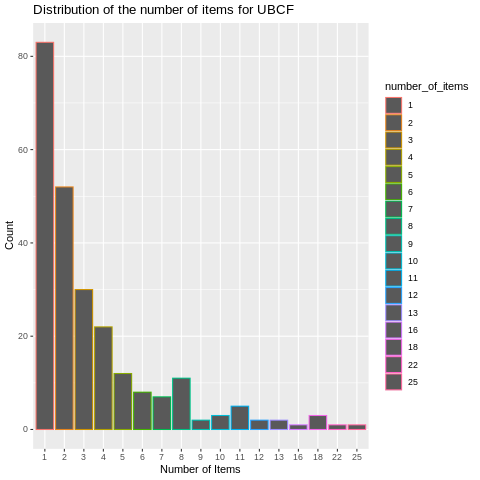

In [63]:
%%R
number_of_items <- factor(table(recc_matrix))
chart_title <- "Distribution of the number of items for UBCF"
qplot(number_of_items,xlab="Number of Items",ylab="Count",color=number_of_items) + ggtitle(chart_title)

In [64]:
%%R
#the following is the matrix for top titles
number_of_items_sorted <- sort(number_of_items, decreasing = TRUE)
number_of_items_top <- head(number_of_items_sorted, n = 4)
table_top <- data.frame(as.integer(names(number_of_items_top)), number_of_items_top)
for (i in 1:4){
  table_top[i,1] <- as.character(subset(movies, 
                                         movies$movieId == table_top[i,1])$title)
}
colnames(table_top) <- c("Movie title", "No of items")
head(table_top)

                      Movie title No of items
2268       Few Good Men, A (1992)          25
5669 Bowling for Columbine (2002)          22
920     Gone with the Wind (1939)          18
1584               Contact (1997)          18


##EVALUATING AND COMPARING THE MODELS

In [65]:
%%R
#Evaluating the recommender system
#1.Splitting the data
percentage_training <- 0.8
min(rowCounts(ratings_movies)) 
items_to_keep <- 5 #number of items to generate recommendations
rating_threshold <- 3 # threshold with the minimum rating that is considered good
n_eval <- 1 #number of times to run evaluation
eval_sets <- evaluationScheme(data = ratings_movies, 
                              method = "split",
                              train = percentage_training, 
                              given = items_to_keep, 
                              goodRating = rating_threshold, 
                              k = n_eval) 
eval_sets
getData(eval_sets, "train") # training set




336 x 447 rating matrix of class ‘realRatingMatrix’ with 30626 ratings.


In [66]:
%%R
getData(eval_sets, "known") # set with the items used to build the recommendations

84 x 447 rating matrix of class ‘realRatingMatrix’ with 420 ratings.


In [67]:
%%R
getData(eval_sets, "unknown") # set with the items used to test the recommendations

84 x 447 rating matrix of class ‘realRatingMatrix’ with 7295 ratings.


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



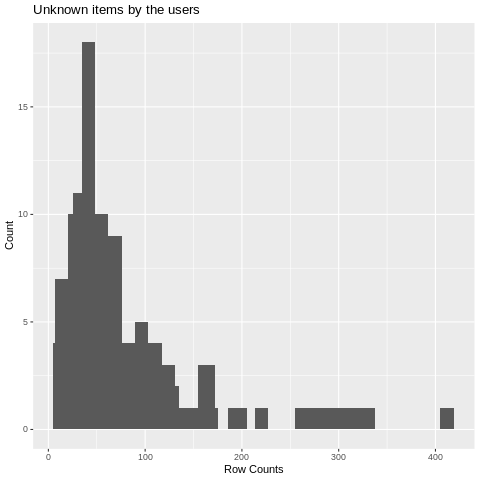

In [68]:
%%R
#a plot for unknown items by the user 
qplot(rowCounts(getData(eval_sets, "unknown")),xlab="Row Counts", ylab="Count") + 
  geom_histogram(binwidth = 10) + 
  ggtitle("Unknown items by the users")


In [69]:
%%R
#Bootstrapping the data 
eval_sets <- evaluationScheme(data = ratings_movies, 
                              method = "bootstrap", 
                              train = percentage_training, 
                              given = items_to_keep,
                              goodRating = rating_threshold, 
                              k = n_eval)
table_train <- table(eval_sets@runsTrain[[1]])
n_repetitions <- factor(as.vector(table_train))


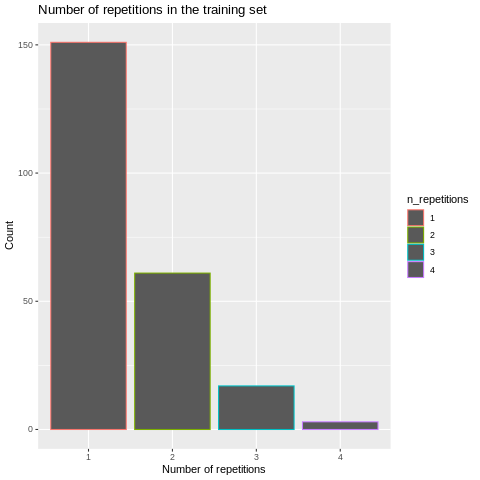

In [70]:
%%R
#most of the users have been sampled fewer than four times.
qplot(n_repetitions,xlab="Number of repetitions",ylab="Count",color=n_repetitions) + 
ggtitle("Number of repetitions in the training set")

In [71]:
%%R
#using cross validation to validate the models
n_fold <- 4
eval_sets <- evaluationScheme(data = ratings_movies, 
                              method = "cross-validation",
                              k = n_fold, 
                              given = items_to_keep, 
                              goodRating = rating_threshold)
size_sets <- sapply(eval_sets@runsTrain, length)
size_sets

[1] 315 315 315 315


In [72]:
%%R
#evaluating the ratings using k-fold approach
eval_sets <- evaluationScheme(data = ratings_movies, 
                              method = "cross-validation",
                              k = n_fold, 
                              given = items_to_keep, 
                              goodRating = rating_threshold)
model_to_evaluate <- "IBCF"
model_parameters <- NULL
eval_recommender <- Recommender(data = getData(eval_sets, "train"),
                                method = model_to_evaluate, 
                                parameter = model_parameters)
items_to_recommend <- 10
eval_prediction <- predict(object = eval_recommender, 
                           newdata = getData(eval_sets, "known"), 
                           n = items_to_recommend, 
                           type = "ratings")

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



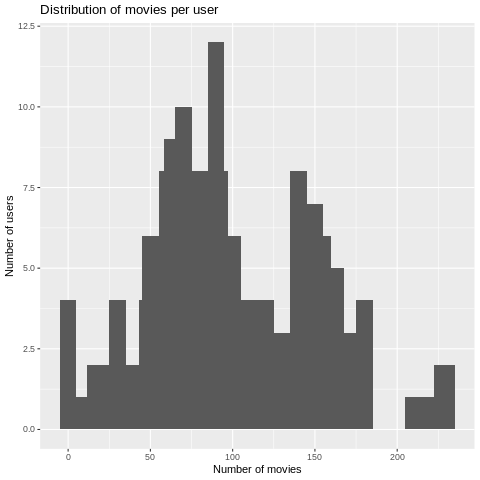

In [73]:
%%R
#plot for the distribution of movies per user in the matrix of predicted ratings.
qplot(rowCounts(eval_prediction),xlab="Number of movies",ylab="Number of users") + 
  geom_histogram(binwidth = 10) +
  ggtitle("Distribution of movies per user")

In [74]:
%%R
#computing accuracy measures for each user using root mean square error 
eval_accuracy <- calcPredictionAccuracy(x = eval_prediction, 
                                        data = getData(eval_sets, "unknown"), 
                                        byUser = TRUE)
head(eval_accuracy)

          RMSE       MSE       MAE
[1,] 1.0000000 1.0000000 0.6000000
[2,] 1.7099981 2.9240936 1.5779358
[3,] 0.7071068 0.5000000 0.6666667
[4,] 0.0000000 0.0000000 0.0000000
[5,] 1.0000000 1.0000000 0.7333333
[6,] 0.5958727 0.3550643 0.5318255


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



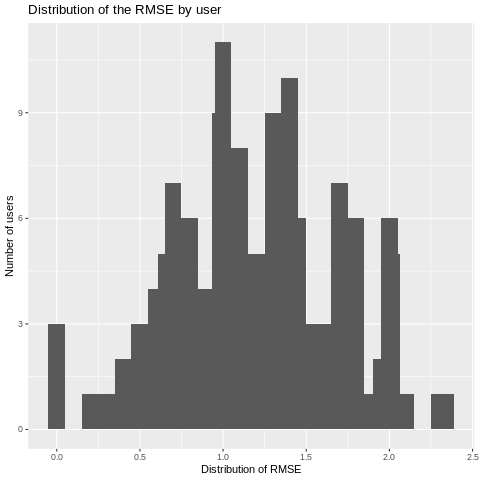

In [75]:
%%R
#distribution plot of RMSE plot
qplot(eval_accuracy[, "RMSE"],xlab="Distribution of RMSE",ylab="Number of users") + 
geom_histogram(binwidth = 0.1) +
ggtitle("Distribution of the RMSE by user")

In [76]:
%%R
#performance index of the model
eval_accuracy <- calcPredictionAccuracy(x = eval_prediction, 
                                        data = getData(eval_sets, "unknown"), 
                                        byUser = FALSE) 
eval_accuracy

    RMSE      MSE      MAE 
1.370016 1.876945 1.034645 


In [77]:
%%R
#evaluating the recommendation system
results <- evaluate(x = eval_sets, 
                    method = model_to_evaluate, 
                    n = seq(10, 100, 10))
head(getConfusionMatrix(results)[[1]])

IBCF run fold/sample [model time/prediction time]
	 1  [0.23sec/0.023sec] 
	 2  [0.236sec/0.023sec] 
	 3  [0.216sec/0.022sec] 
	 4  [0.219sec/0.023sec] 
           TP        FP       FN       TN   N precision     recall        TPR
[1,] 1.533333  8.066667 73.16190 359.2381 442 0.1599010 0.02133007 0.02133007
[2,] 2.895238 16.180952 71.80000 351.1238 442 0.1522798 0.03892414 0.03892414
[3,] 4.380952 23.990476 70.31429 343.3143 442 0.1548948 0.05795658 0.05795658
[4,] 5.704762 31.657143 68.99048 335.6476 442 0.1529453 0.07490784 0.07490784
[5,] 7.161905 38.885714 67.53333 328.4190 442 0.1553648 0.09305041 0.09305041
[6,] 8.466667 45.790476 66.22857 321.5143 442 0.1559708 0.10774507 0.10774507
            FPR  n
[1,] 0.02223484 10
[2,] 0.04431380 20
[3,] 0.06548322 30
[4,] 0.08653325 40
[5,] 0.10620395 50
[6,] 0.12491303 60


In [78]:
%%R
#looking at all the splits at once 
columns_to_sum <- c("TP", "FP", "FN", "TN")
indices_summed <- Reduce("+", getConfusionMatrix(results))[, columns_to_sum]
head(indices_summed)

            TP        FP       FN       TN
[1,]  6.838095  32.17143 295.3333 1433.657
[2,] 13.371429  64.29524 288.8000 1401.533
[3,] 19.523810  96.37143 282.6476 1369.457
[4,] 25.447619 127.25714 276.7238 1338.571
[5,] 30.971429 156.83810 271.2000 1308.990
[6,] 35.857143 184.76190 266.3143 1281.067


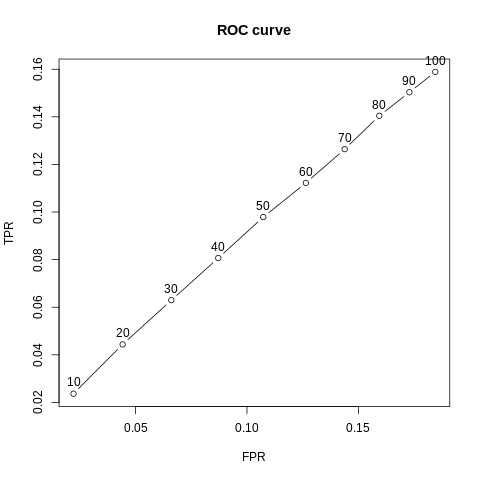

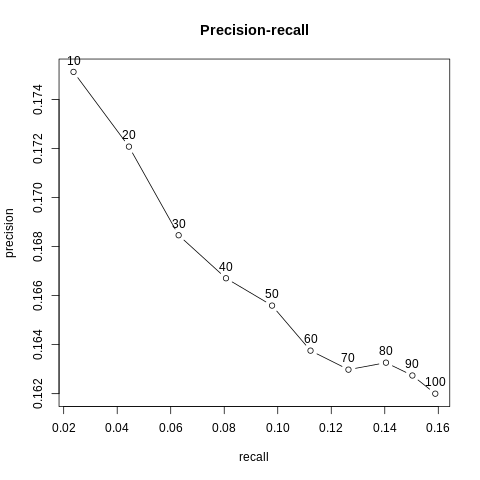

In [84]:
%%R
#plot of the ROC and precision/recall :
plot(results, annotate = TRUE, main = "ROC curve")
plot(results, "prec/rec", annotate = TRUE, main = "Precision-recall")

In [90]:
%%R
models_to_evaluate <- list(
IBCF_cos = list(name = "IBCF", 
                param = list(method = "cosine")),
IBCF_cor = list(name = "IBCF", 
                param = list(method = "pearson")),
UBCF_cos = list(name = "UBCF", 
                param = list(method = "cosine")),
UBCF_cor = list(name = "UBCF", 
                param = list(method = "pearson")),
random = list(name = "RANDOM", param=NULL)
)

In [91]:
%%R
#comparing the models with different set of numbers 
n_recommendations <- c(1, 5, seq(10, 100, 10))
list_results <-evaluate(x = eval_sets, method = models_to_evaluate, n = n_recommendations)
sapply(list_results, class) == "evaluationResults"

IBCF run fold/sample [model time/prediction time]
	 1  [0.214sec/0.023sec] 
	 2  [0.225sec/0.037sec] 
	 3  [0.224sec/0.022sec] 
	 4  [0.218sec/0.023sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [0.258sec/0.021sec] 
	 2  [0.259sec/0.021sec] 
	 3  [0.262sec/0.022sec] 
	 4  [0.257sec/0.022sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0.008sec/0.198sec] 
	 2  [0.009sec/0.211sec] 
	 3  [0.009sec/0.21sec] 
	 4  [0.009sec/0.197sec] 
UBCF run fold/sample [model time/prediction time]
	 1  

R[write to console]: Timing stopped at: 0.051 0.001 0.048

R[write to console]: Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': not-yet-implemented method for <dgCMatrix> %*% <list>



RANDOM run fold/sample [model time/prediction time]
	 1  [0.002sec/0.067sec] 
	 2  [0.002sec/0.041sec] 
	 3  [0.002sec/0.046sec] 
	 4  [0.002sec/0.051sec] 
IBCF_cos IBCF_cor UBCF_cos   random 
    TRUE     TRUE     TRUE     TRUE 


In [92]:
%%R
#first rows of the performance evaluation matrix for the IBCF with Cosine distance:
avg_matrices <- lapply(list_results, avg)
head(avg_matrices$IBCF_cos[, 5:8])

       N precision      recall         TPR
[1,] 442 0.1802251 0.002525558 0.002525558
[2,] 442 0.1705864 0.011397671 0.011397671
[3,] 442 0.1751299 0.023671562 0.023671562
[4,] 442 0.1720810 0.044386551 0.044386551
[5,] 442 0.1684642 0.062960299 0.062960299
[6,] 442 0.1667094 0.080659272 0.080659272


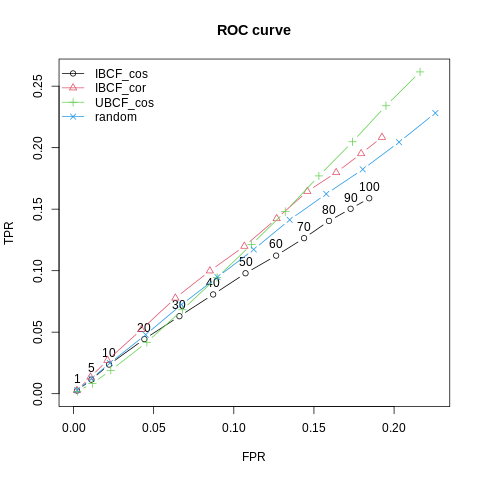

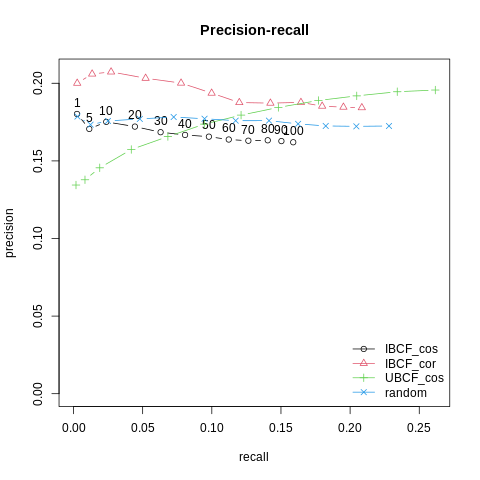

In [93]:
%%R
#identifying the most suitable model
plot(list_results, annotate = 1, legend = "topleft") 
title("ROC curve")
plot(list_results, "prec/rec", annotate = 1, legend = "bottomright")
title("Precision-recall")

In [94]:
%%R
#optimizing the IBCF numeric parameter 
vector_k <- c(5, 10, 20, 30, 40)
models_to_evaluate <- lapply(vector_k, function(k){
  list(name = "IBCF",
       param = list(method = "cosine", k = k))
})
names(models_to_evaluate) <- paste0("IBCF_k_", vector_k)

In [95]:
%%R
#evaluate the same IBCF/cosine models with different values of the k-closest items:
n_recommendations <- c(1, 5, seq(10, 100, 10))
list_results <- evaluate(x = eval_sets, 
                         method = models_to_evaluate, 
                         n = n_recommendations)

IBCF run fold/sample [model time/prediction time]
	 1  [0.213sec/0.017sec] 
	 2  [0.218sec/0.018sec] 
	 3  [0.223sec/0.018sec] 
	 4  [0.221sec/0.017sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [0.218sec/0.018sec] 
	 2  [0.221sec/0.018sec] 
	 3  [0.228sec/0.019sec] 
	 4  [0.225sec/0.017sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [0.227sec/0.02sec] 
	 2  [0.211sec/0.02sec] 
	 3  [0.213sec/0.02sec] 
	 4  [0.224sec/0.02sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [0.229sec/0.024sec] 
	 2  [0.222sec/0.021sec] 
	 3  [0.229sec/0.023sec] 
	 4  [0.234sec/0.021sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [0.224sec/0.027sec] 
	 2  [0.243sec/0.024sec] 
	 3  [0.219sec/0.025sec] 
	 4  [0.239sec/0.024sec] 


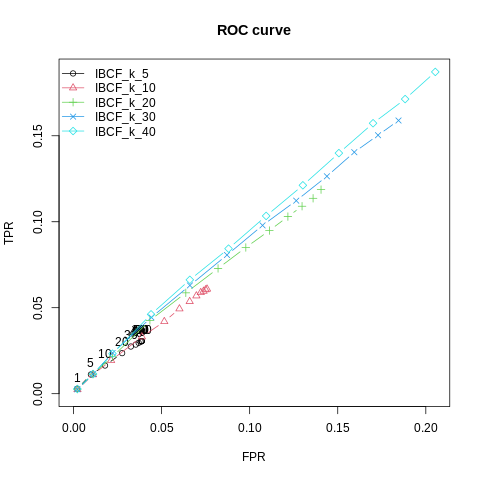

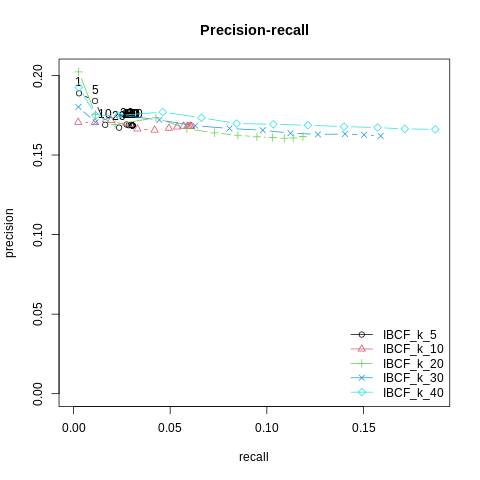

In [96]:
%%R
#ROC and precision/recall plot 
plot(list_results, annotate = 1, legend = "topleft") 
title("ROC curve")
plot(list_results, "prec/rec", annotate = 1, legend = "bottomright")
title("Precision-recall")